# **INTRODUTION**
Hi! I'm Pragya, and this is my first-ever submission to a Kaggle competition—also my first step into the world of computer vision!

I'm fascinated by all things data, and this competition felt like the perfect opportunity to dive in and learn. For me, this isn't about winning—it's about challenging myself, stepping out of my comfort zone, and embracing the learning process.

If you're a beginner like me, constantly feeling overwhelmed and trapped by the fear that this is beyond your reach—you're not alone!  This notebook is my way of documenting the journey, breaking things down step by step, and making it more approachable.


Feel free to follow along, experiment, and learn with me! 

PS: I use excessive comments. Hope it adds to your learning experience :)

# **UNDERSTADING THE CHALLENGE**

Qn: So, what's this challenge about but in "Simpler Terms" ?

A : This challenge is about Image Matching—which means identifying which images belong to the same place (scene) and estimating how the camera moved between them.

Imagine there's a robot exploring an unknown place. It captures a bunch of images from different angles.
Our job is to:

1) Group images that belong to the same scene/place.

2) Find out how the camera moved when capturing each image (its rotation & position).

We'll understand more about the challenge as we move along!

In [1]:
#LOADING THE DATASET

import os #For file and directory operations (ex: checking dataset structure)

# List all files in dataset directory
dataset_path = "/kaggle/input/"
os.listdir(dataset_path)
#Just to ensure that the dataset is already there! 
#(Kaggle usually mounts the competition dataset automatically in /kaggle/input/)

['image-matching-challenge-2025']

In [2]:
#EXPLORING THE DATASET STRUCTURE

dataset_path = "/kaggle/input/image-matching-challenge-2025"

# Check files inside (list the available folders)
os.listdir(dataset_path)

['sample_submission.csv',
 'train_thresholds.csv',
 'train_labels.csv',
 'test',
 'train']

# **UNDERSTANDING THE DATASET**

Download the dataset locally and explore it first.
The dataset contains:
* train/ → Training images (labeled with scenes)
* test/ → Test images (we need to predict scene clusters & camera poses)
* train_thresholds.csv → Provides similarity thresholds for deciding if two images match.
* train_labels.csv → Defines which images belong to the same scene in the training set.
* sample_submission.csv → Shows the required submission format.

Let's focus on the training dataset for now.
For Example: Open the "imc2024_lizard_pond" subfolder in the training dataset.
we'll find images with different naming patterns:

* "lizard_X" → Images of the lizard scene
* "pond_X" → Images of the pond scene3)
* "outliers_img_X" → Irrelevant images that don’t belong to the lizard or pond


Each folder is a mix of multiple puzzles that need to be sorted into their own box!
Hence, our job is to:
1) Identify and group images that belong to the same scene (e.g., all lizard images together, all pond images together).
2) Remove outliers that don’t fit into any scene.
3)  Estimate how the camera moved between the images in a scene.

# **EXPLORATORY DATA ANALYSIS**

The first and most crucial step for anything involving data- EDA!

In [3]:
# Importing necessary libraries 

import numpy as np  # For numerical operations (arrays, math, etc.)
import pandas as pd  # For handling CSV files (reading, writing, manipulating tables)
import matplotlib.pyplot as plt  # For visualizing images
from PIL import Image  # To open and inspect images

In [4]:
# Loading train_labels.csv file
train_path = "../input/image-matching-challenge-2025/train" 
train_labels = pd.read_csv('/kaggle/input/image-matching-challenge-2025/train_labels.csv')

# Displaying first few rows of it
train_labels.head()

,dataset,scene,image,rotation_matrix,translation_vector
0,imc2023_haiper,fountain,fountain_image_116.png,0.122655949;0.947713775;-0.294608417;0.1226706...,0.093771314;-0.803560988;2.062001533
1,imc2023_haiper,fountain,fountain_image_108.png,0.474305910;0.359108654;-0.803787832;0.2888416...,0.358946647;-0.797557548;1.910906929
2,imc2023_haiper,fountain,fountain_image_101.png,0.565115476;-0.138485064;-0.813305838;0.506678...,0.146922468;-0.981392596;2.009002852
3,imc2023_haiper,fountain,fountain_image_082.png,-0.308320392;-0.794654112;0.522937261;0.948141...,0.206413831;-1.174321103;3.667167680
4,imc2023_haiper,fountain,fountain_image_071.png,-0.569002830;-0.103808175;0.815757098;0.778745...,-0.015140892;-1.334052012;3.488936597


In [5]:
# Check dataset info (column names, data types, missing values)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945 entries, 0 to 1944
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   dataset             1945 non-null   object
 1   scene               1945 non-null   object
 2   image               1945 non-null   object
 3   rotation_matrix     1945 non-null   object
 4   translation_vector  1945 non-null   object
dtypes: object(5)
memory usage: 76.1+ KB


Each row of train_labels. csv file represents one image and gives us:

1) dataset → The dataset name it belongs to (e.g., imc2023_haiper).

2) scene → The scene category (e.g., all images with fountain are from the same place).

3) image → The filename of the image.

4) rotation_matrix → Camera rotation matrix (used to determine the angle of capture).

5) translation_vector → Camera translation vector (used to determine the position shift).


The goal of the challenge is to group images that belong to the same location (scene).
Each scene (e.g., "fountain") has multiple images taken from different angles and positions.
The rotation_matrix and translation_vector tell us how much the camera moved between shots.

We need to use this information to match images that belong together in the test set.

In [6]:
#SOME KEY QUESTIONS TO ADDRESS:

# Qn1. How many unique scenes are there?

# Ans. Number of unique scenes
num_scenes = train_labels["scene"].nunique()
num_scenes

30

In [7]:

# Qn2. How many images per scene?

# Ans. Count images per scene
scene_counts = train_labels["scene"].value_counts()
scene_counts

scene
peach                   200
dioscuri                140
outliers                122
grand_place_brussels    100
st_peters_square        100
st_pauls_cathedral      100
lizard                   90
pond                     90
vineyard_split_3         85
british_museum           75
taj_mahal                75
sacre_coeur              75
trevi_fountain           75
buckingham_palace        75
brandenburg_gate         75
piazza_san_marco         68
church                   50
baalshamin               49
vineyard_split_1         43
wall                     43
vineyard_split_2         35
cyprus                   30
stairs_split_1           28
kyiv-puppet-theater      26
fountain                 23
stairs_split_2           23
chairs                   16
bike                     15
another_ET               10
ET                        9
Name: count, dtype: int64

In [8]:
#Qn3. How many datasets (different sources of images)?

#Ans. 
# Number of unique datasets
num_datasets = train_labels["dataset"].nunique()
num_datasets

13

In [9]:
# Count images per dataset
dataset_counts = train_labels["dataset"].value_counts()
dataset_counts

dataset
pt_brandenburg_british_buckingham    225
pt_sacrecoeur_trevi_tajmahal         225
imc2024_lizard_pond                  214
imc2023_heritage                     209
pt_stpeters_stpauls                  200
amy_gardens                          200
pt_piazzasanmarco_grandplace         168
fbk_vineyard                         163
imc2024_dioscuri_baalshamin          138
imc2023_theather_imc2024_church       76
imc2023_haiper                        54
stairs                                51
ETs                                   22
Name: count, dtype: int64

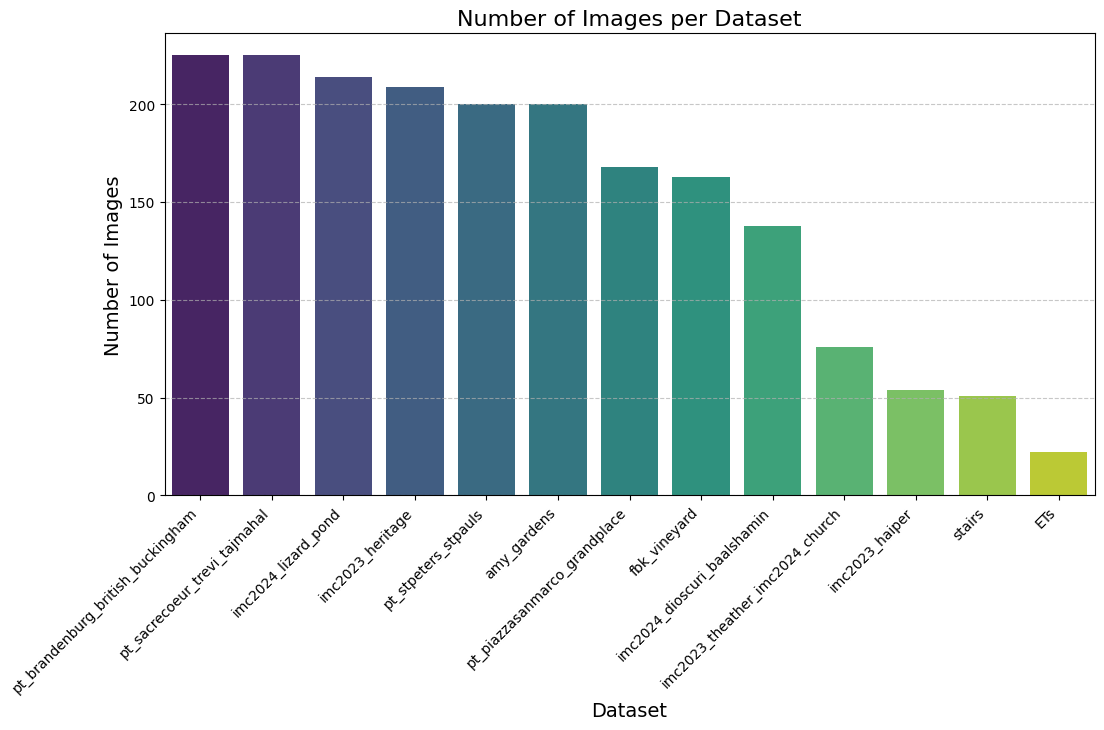

In [10]:
import seaborn as sns

# Counting images per dataset
dataset_counts = train_labels["dataset"].value_counts()

# Plotting the bar chart
plt.figure(figsize=(12, 6))  # Set figure size
sns.barplot(x=dataset_counts.index, y=dataset_counts.values, palette="viridis")  # Use seaborn for better styling

# Adding labels and title
plt.xlabel("Dataset", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.title("Number of Images per Dataset", fontsize=16)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add a light grid for clarity

# Show the plot
plt.show()

In [11]:
train_thresholds_path = "../input/image-matching-challenge-2025/train_thresholds.csv"
train_thresholds = pd.read_csv(train_thresholds_path)
train_thresholds.head() 

,dataset,scene,thresholds
0,amy_gardens,peach,0.01;0.02;0.05;0.1;0.25;0.5
1,ETs,ET,0.002;0.005;0.008;0.01;0.02;0.04
2,ETs,another_ET,0.002;0.005;0.008;0.01;0.02;0.04
3,fbk_vineyard,vineyard_split_1,0.01;0.02;0.05;0.1;0.25;0.5
4,fbk_vineyard,vineyard_split_2,0.01;0.02;0.05;0.1;0.25;0.5


In [12]:
# Describe thresholds data
train_thresholds.describe()

,dataset,scene,thresholds
count,30,30,30
unique,13,29,5
top,fbk_vineyard,dioscuri,0.05;0.1;0.2;0.5;1.0;2.0
freq,3,2,10


**The Concept of Thresholds**

Qn) What do these thresholds mean?

Ans) A threshold is a predefined similarity score that determines if two images are a match or not. Each scene (e.g., peach, ET, vineyard_split_1) has a set of similarity score thresholds.


Let’s say we have a scene called "peach" in the dataset amy_gardens.

Its thresholds are: 0.01; 0.02; 0.05; 0.1; 0.25; 0.5.

Now, imagine we compare two images from this scene and calculate their similarity score (using image-matching techniques like feature descriptors).

* If their similarity score is 0.008, it's below the lowest threshold (0.01), meaning they're probably not a match.
* If their similarity score is 0.07, it's between 0.05 and 0.1, so maybe they match.
* If their similarity score is 0.4, it's below 0.5, so they are likely a match.

Each threshold represents a different level of strictness in image matching. Imagine you’re trying to match two images of the same place.

You need a rule to say: "If the similarity score is below X, the images are from the same scene."

These thresholds act as cutoff points for deciding whether two images belong to the same scene.

* If a similarity score falls below the lowest threshold, the images are very different and likely not a match.
* If a similarity score falls above the highest threshold, the images are highly similar and almost certainly a match.
* If a similarity score falls in between two thresholds, the confidence in the match is uncertain—it could go either way.

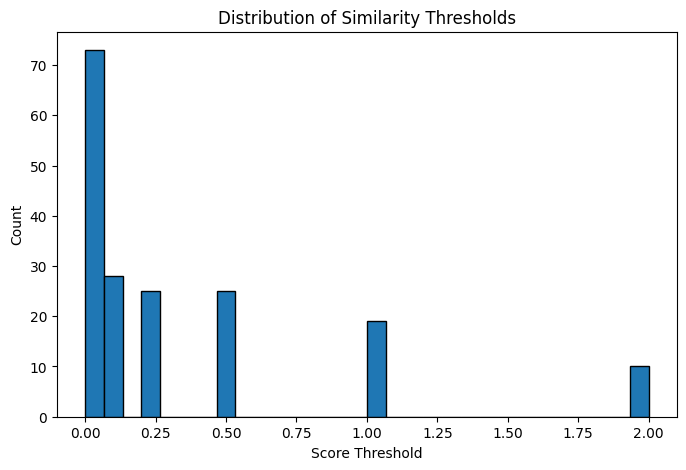

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Convert the "thresholds" column into a list of lists (split by ";")
threshold_lists = train_thresholds["thresholds"].apply(lambda x: list(map(float, x.split(";"))))

# Step 2: Flatten the list (convert list of lists into a single list)
all_thresholds = np.concatenate(threshold_lists.values)

# Step 3: Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(all_thresholds, bins=30, edgecolor="black")
plt.xlabel("Score Threshold")
plt.ylabel("Count")
plt.title("Distribution of Similarity Thresholds")
plt.show()


Graph Interpretation: 

* The tallest bar at 0.00 indicates that many image pairs have very low similarity thresholds.
This suggests that the dataset contains mostly non-matching or weakly similar images.
* There are spikes at 0.5 and 1.0, meaning some datasets allow looser similarity measures.
* The bar at 2.00 is quite small, meaning very few image pairs are highly similar.
Hence the dataset has limited exact matches.

# **LOADING AND VISUALIZING IMAGES**


Since our task is image matching, let’s pick two images from the same scene and display them.

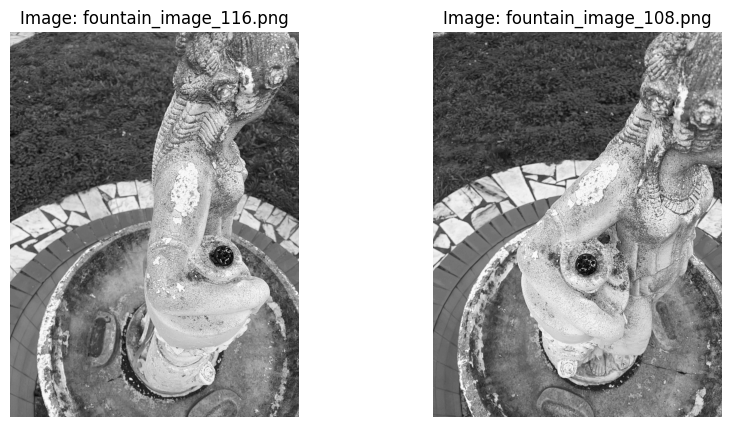

In [14]:
import cv2  # OpenCV library for image processing

# Pick a scene from the dataset
scene_name = "fountain"  
scene_images = train_labels[train_labels["scene"] == scene_name]["image"].values[:2]  # Picked two images

# Load and display images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, img_name in enumerate(scene_images):
    img_path = os.path.join(train_path, train_labels[train_labels["scene"] == scene_name]["dataset"].values[0], img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Loaded image in grayscale (easier for feature matching)
    
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Image: {img_name}")
    axes[i].axis("off")

plt.show()

# **IMAGE MATCHING TECHNIQUES**

Two of the most common approaches of image matching are: 
* Feature-based matching
* Template Matching

We'll explore only some introduction to Feature-based matching in this notebook.

This method involves identifying distinctive features (such as corners, edges, or blobs) in the images and matching them based on their descriptors. Some common and popular algorithms used for feature-based matching include SIFT (Scale-Invariant Feature Transform), SURF (Speeded-Up Robust Features),  ORB (Oriented FAST and Rotated BRIEF), AKAZE (Accelerated-KAZE),  BRISK (Binary Robust Invariant Scalable Keypoints), and FREAK (Fast Retina Keypoint).

Feature based matching involves following two important steps: 

* Detect keypoints and descriptors: Detect distinctive points or regions in both images that are likely to be matched and extract numerical descriptors or feature vectors around each keypoint to describe its local neighborhood. These descriptors should be distinctive and invariant to changes in scale, rotation, and illumination. Algorithms such as SIFT used for this process.

* Match keypoints: Compare the descriptors of keypoints between the two images to find correspondences. We may apply filtering techniques to remove incorrect matches and retain only reliable correspondences. Different feature matcher such as Brute-Force matcher, FLANN matcher are used for this process.

## **Feature Matching using ORB**

We'll start with ORB (Oriented FAST and Rotated BRIEF). Why? 

ORB is optimized for speed. It works well even when images are rotated or slightly scaled and it offers a decent trade-off between speed and accuracy. (And yes it's beginner friendly!)

Now, let’s detect keypoints and match features between these two images.

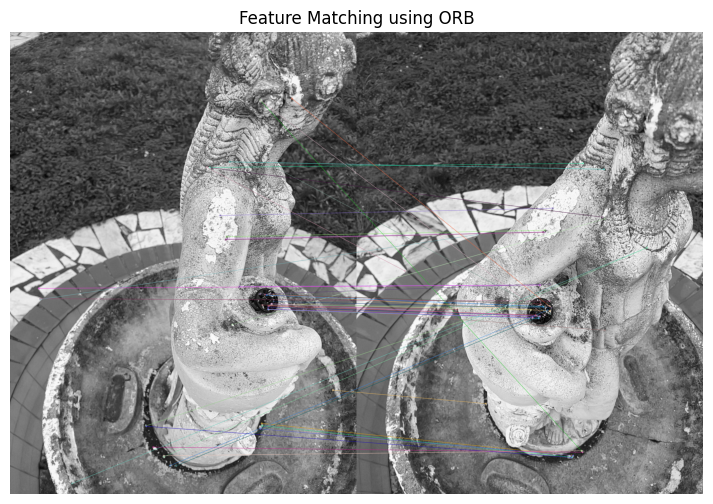

In [15]:
# Load the two images for matching
img1 = cv2.imread(os.path.join(train_path, train_labels[train_labels["scene"] == scene_name]["dataset"].values[0], scene_images[0]), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join(train_path, train_labels[train_labels["scene"] == scene_name]["dataset"].values[0], scene_images[1]), cv2.IMREAD_GRAYSCALE)

# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Initialize Brute-Force Matcher and match descriptors
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance (lower distance = better match)
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matching result
plt.figure(figsize=(12, 6))
plt.imshow(match_img)
plt.title("Feature Matching using ORB")
plt.axis("off")
plt.show()

Image Description: 
* ORB detects keypoints (unique patterns in the image).
* It computes descriptors (numerical representations of those keypoints).
* It matches descriptors between two images.
* The matches are visualized with lines connecting keypoints in both images.

In [16]:
#making a dummy file valid for submission

sample_submission = pd.read_csv('/kaggle/input/image-matching-challenge-2025/sample_submission.csv')
#sample_submission.head()
#checking column named to have in dummy submission

# Create dummy values
sample_submission["rotation_matrix"] = "1;0;0;0;1;0;0;0;1"  # Identity matrix as a placeholder
sample_submission["translation_vector"] = "0;0;0"  # Zero translation

# Save the dummy submission file
sample_submission.to_csv("submission.csv", index=False)

print("Dummy submission file created successfully!")

Dummy submission file created successfully!


**THANK YOU !!!**

Thank you so much for checking out my work! 🙏
This notebook was just a quick introduction to give you a basic idea of what the Image Matching Challenge is all about—and what’s in store for us.

The next notebook will dive deeper into Feature Matching!
This was just a small taste of what's to come.

Feel free to upvote if you enjoyed it or found it helpful! 😊


PS I'm open to constructive criticism! Any suggestions are welcomed!

# **SOURCES AND CITATIONS**
* https://blog.roboflow.com/image-matching/    (Intro to Image Matching)
* https://youtu.be/0sPlnrEMyYk?feature=shared  (What is ORB?)